# 1. Preparación de Datos para Clasificación de Enfermedades en Plantas

Este notebook prepara el dataset Plant Village para el entrenamiento de modelos de clasificación de enfermedades en plantas.

## Objetivos:
- Cargar y organizar el dataset
- Preprocesar las imágenes
- Dividir en conjuntos de entrenamiento, validación y prueba
- Aplicar técnicas de data augmentation

## Dataset: Plant Village
- **Especies**: 14 especies de plantas
- **Clases**: 38 clases (sanas y enfermas)
- **Total imágenes**: ~54,000 imágenes
- **Resolución**: Variable, se redimensionará a 224x224

In [1]:
# Importar librerías necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Configurar reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
Keras version: 3.12.0
GPU disponible: []


In [2]:
# Configuración de rutas y parámetros
DATA_DIR = Path('./data/PlantDisease')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

print(f"Directorio de datos: {DATA_DIR}")
print(f"Tamaño de imagen objetivo: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Directorio de datos: data\PlantDisease
Tamaño de imagen objetivo: (224, 224)
Batch size: 32


In [3]:
# Explorar estructura del dataset
def explorar_dataset(data_dir):
    """
    Explora la estructura del dataset y cuenta imágenes por clase
    """
    clases = []
    conteo_imagenes = []
    
    print("Estructura del dataset:")
    print("=" * 50)
    
    for clase_dir in sorted(data_dir.iterdir()):
        if clase_dir.is_dir():
            num_imagenes = len(list(clase_dir.glob('*.JPG')) + list(clase_dir.glob('*.jpg')))
            clases.append(clase_dir.name)
            conteo_imagenes.append(num_imagenes)
            print(f"{clase_dir.name}: {num_imagenes} imágenes")
    
    return clases, conteo_imagenes

clases, conteos = explorar_dataset(DATA_DIR)
print(f"\nTotal de clases: {len(clases)}")
print(f"Total de imágenes: {sum(conteos)}")

Estructura del dataset:
Pepper__bell___Bacterial_spot: 1994 imágenes
Pepper__bell___healthy: 2954 imágenes
Potato___Early_blight: 2000 imágenes
Potato___healthy: 304 imágenes
Potato___Late_blight: 2000 imágenes
Tomato__Target_Spot: 2808 imágenes
Tomato__Tomato_mosaic_virus: 746 imágenes
Tomato__Tomato_YellowLeaf__Curl_Virus: 6416 imágenes
Tomato_Bacterial_spot: 4254 imágenes
Tomato_Early_blight: 2000 imágenes
Tomato_healthy: 3182 imágenes
Tomato_Septoria_leaf_spot: 3542 imágenes
Tomato_Spider_mites_Two_spotted_spider_mite: 3352 imágenes

Total de clases: 13
Total de imágenes: 35552


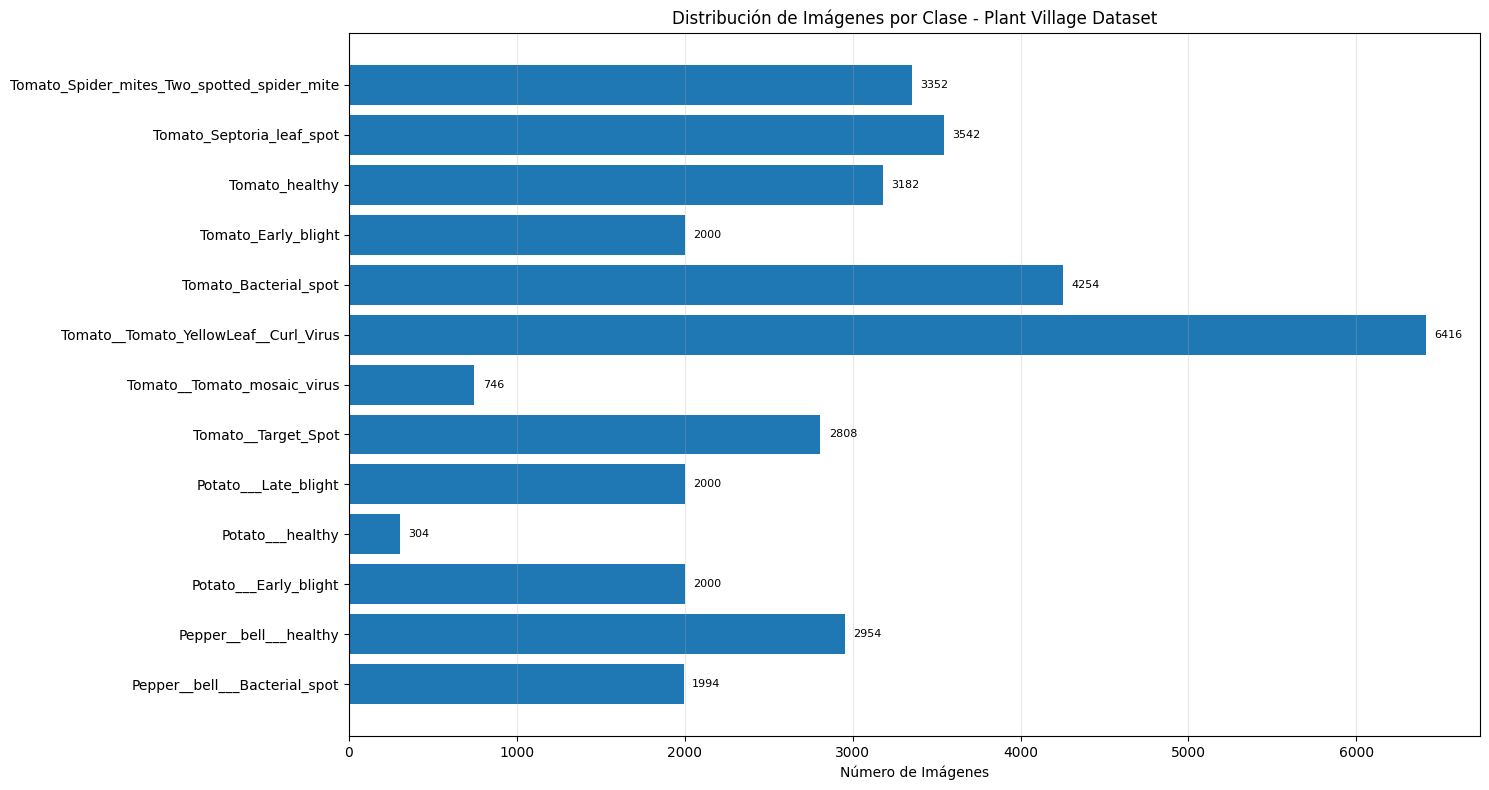

Promedio de imágenes por clase: 2734.8
Desviación estándar: 1498.1
Clase con más imágenes: Tomato__Tomato_YellowLeaf__Curl_Virus (6416 imágenes)
Clase con menos imágenes: Potato___healthy (304 imágenes)


In [4]:
# Visualizar distribución de clases
plt.figure(figsize=(15, 8))
plt.barh(range(len(clases)), conteos)
plt.yticks(range(len(clases)), clases, fontsize=10)
plt.xlabel('Número de Imágenes')
plt.title('Distribución de Imágenes por Clase - Plant Village Dataset')
plt.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(conteos):
    plt.text(v + 50, i, str(v), va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Estadísticas básicas
print(f"Promedio de imágenes por clase: {np.mean(conteos):.1f}")
print(f"Desviación estándar: {np.std(conteos):.1f}")
print(f"Clase con más imágenes: {clases[np.argmax(conteos)]} ({max(conteos)} imágenes)")
print(f"Clase con menos imágenes: {clases[np.argmin(conteos)]} ({min(conteos)} imágenes)")

In [5]:
# Crear DataFrame con información de imágenes
def crear_dataframe_imagenes(data_dir):
    """
    Crea un DataFrame con información de todas las imágenes
    """
    datos = []
    
    for clase_dir in data_dir.iterdir():
        if clase_dir.is_dir():
            clase = clase_dir.name
            
            # Extraer información de la clase
            if '___' in clase:
                especie, condicion = clase.split('___')
            else:
                # Para casos como "Tomato_healthy"
                partes = clase.split('_')
                if len(partes) > 1:
                    especie = partes[0]
                    condicion = '_'.join(partes[1:])
                else:
                    especie = clase
                    condicion = 'unknown'
            
            # Estado de salud (sana o enferma)
            es_sana = 'healthy' in condicion.lower()
            
            # Procesar cada imagen
            for img_path in clase_dir.glob('*.JPG'):
                datos.append({
                    'ruta': str(img_path),
                    'clase': clase,
                    'especie': especie,
                    'condicion': condicion,
                    'es_sana': es_sana,
                    'nombre_archivo': img_path.name
                })
    
    return pd.DataFrame(datos)

df_imagenes = crear_dataframe_imagenes(DATA_DIR)
print(f"DataFrame creado con {len(df_imagenes)} imágenes")
print(f"\nPrimeras filas:")
print(df_imagenes.head())

DataFrame creado con 17776 imágenes

Primeras filas:
                                                ruta  \
0  data\PlantDisease\Pepper__bell___Bacterial_spo...   
1  data\PlantDisease\Pepper__bell___Bacterial_spo...   
2  data\PlantDisease\Pepper__bell___Bacterial_spo...   
3  data\PlantDisease\Pepper__bell___Bacterial_spo...   
4  data\PlantDisease\Pepper__bell___Bacterial_spo...   

                           clase       especie       condicion  es_sana  \
0  Pepper__bell___Bacterial_spot  Pepper__bell  Bacterial_spot    False   
1  Pepper__bell___Bacterial_spot  Pepper__bell  Bacterial_spot    False   
2  Pepper__bell___Bacterial_spot  Pepper__bell  Bacterial_spot    False   
3  Pepper__bell___Bacterial_spot  Pepper__bell  Bacterial_spot    False   
4  Pepper__bell___Bacterial_spot  Pepper__bell  Bacterial_spot    False   

                                      nombre_archivo  
0  0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Sp...  
1  006adb74-934f-448f-a14f-62181742127b___JR_B.Sp

Análisis por especie:
especie
Tomato          13150
Pepper__bell     2474
Potato           2152
Name: count, dtype: int64

Análisis por estado de salud:
Plantas sanas: 3220 (18.1%)
Plantas enfermas: 14556 (81.9%)


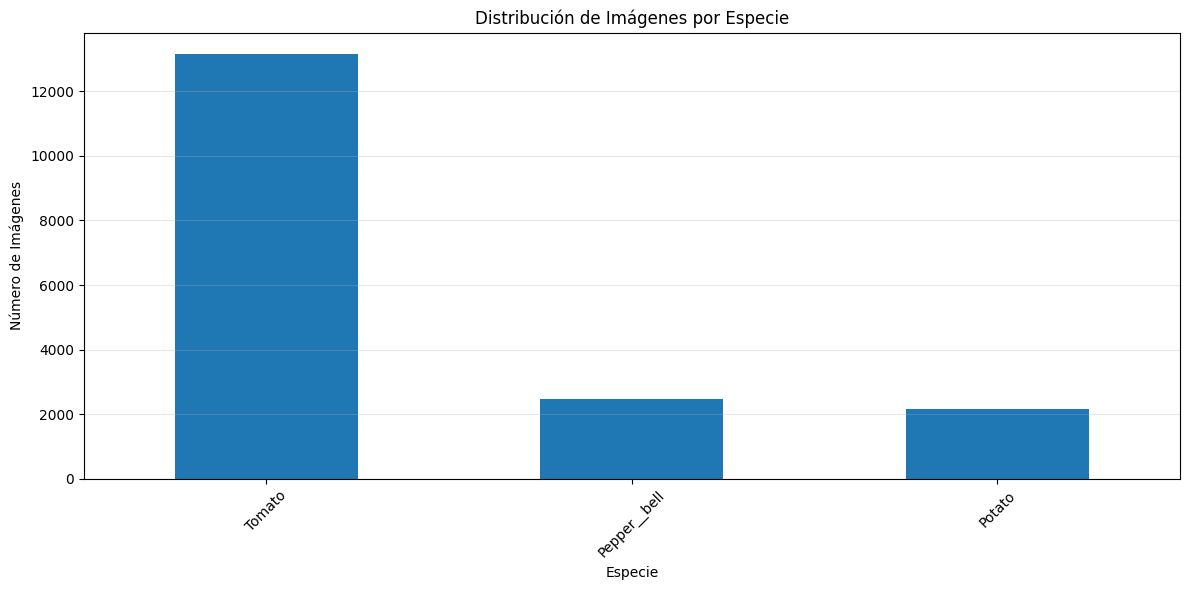

In [6]:
# Análisis por especies y condiciones
print("Análisis por especie:")
especies_count = df_imagenes['especie'].value_counts()
print(especies_count)

print("\nAnálisis por estado de salud:")
salud_count = df_imagenes['es_sana'].value_counts()
print(f"Plantas sanas: {salud_count[True]} ({salud_count[True]/len(df_imagenes)*100:.1f}%)")
print(f"Plantas enfermas: {salud_count[False]} ({salud_count[False]/len(df_imagenes)*100:.1f}%)")

# Visualizar distribución por especie
plt.figure(figsize=(12, 6))
especies_count.plot(kind='bar')
plt.title('Distribución de Imágenes por Especie')
plt.xlabel('Especie')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Codificar etiquetas
label_encoder = LabelEncoder()
df_imagenes['label_encoded'] = label_encoder.fit_transform(df_imagenes['clase'])

# Guardar el mapeo de etiquetas
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de etiquetas:")
for clase, codigo in sorted(label_mapping.items()):
    print(f"{codigo:2d}: {clase}")

# Guardar información para usar en otros notebooks
np.save('label_encoder_classes.npy', label_encoder.classes_)
df_imagenes.to_csv('dataset_info.csv', index=False)

print(f"\nNúmero total de clases: {len(label_encoder.classes_)}")
print(f"Rango de etiquetas: 0 a {len(label_encoder.classes_) - 1}")

Mapeo de etiquetas:
 0: Pepper__bell___Bacterial_spot
 1: Pepper__bell___healthy
 2: Potato___Early_blight
 3: Potato___Late_blight
 4: Potato___healthy
 5: Tomato_Bacterial_spot
 6: Tomato_Early_blight
 7: Tomato_Septoria_leaf_spot
 8: Tomato_Spider_mites_Two_spotted_spider_mite
 9: Tomato__Target_Spot
10: Tomato__Tomato_YellowLeaf__Curl_Virus
11: Tomato__Tomato_mosaic_virus
12: Tomato_healthy

Número total de clases: 13
Rango de etiquetas: 0 a 12


In [8]:
# División estratificada del dataset
def dividir_dataset(df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Divide el dataset en entrenamiento, validación y prueba de forma estratificada
    """
    # Dividir en entrenamiento+validación y prueba
    train_val, test = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=df['clase']
    )
    
    # Dividir entrenamiento+validación en entrenamiento y validación
    train, val = train_test_split(
        train_val, 
        test_size=val_size, 
        random_state=random_state, 
        stratify=train_val['clase']
    )
    
    return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

train_df, val_df, test_df = dividir_dataset(df_imagenes)

print(f"División del dataset:")
print(f"Entrenamiento: {len(train_df)} imágenes ({len(train_df)/len(df_imagenes)*100:.1f}%)")
print(f"Validación: {len(val_df)} imágenes ({len(val_df)/len(df_imagenes)*100:.1f}%)")
print(f"Prueba: {len(test_df)} imágenes ({len(test_df)/len(df_imagenes)*100:.1f}%)")

# Guardar las divisiones
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

print("\nArchivos de división guardados.")

División del dataset:
Entrenamiento: 11376 imágenes (64.0%)
Validación: 2844 imágenes (16.0%)
Prueba: 3556 imágenes (20.0%)

Archivos de división guardados.


In [9]:
# Verificar balance en cada división
def verificar_balance(train_df, val_df, test_df):
    """
    Verifica el balance de clases en cada división
    """
    print("Balance de clases por división:")
    print("=" * 50)
    
    for nombre, df in [('Entrenamiento', train_df), ('Validación', val_df), ('Prueba', test_df)]:
        print(f"\n{nombre}:")
        clase_counts = df['clase'].value_counts()
        print(f"Clases: {len(clase_counts)}")
        print(f"Min imágenes por clase: {clase_counts.min()}")
        print(f"Max imágenes por clase: {clase_counts.max()}")
        print(f"Promedio por clase: {clase_counts.mean():.1f}")

verificar_balance(train_df, val_df, test_df)

Balance de clases por división:

Entrenamiento:
Clases: 13
Min imágenes por clase: 98
Max imágenes por clase: 2053
Promedio por clase: 875.1

Validación:
Clases: 13
Min imágenes por clase: 24
Max imágenes por clase: 513
Promedio por clase: 218.8

Prueba:
Clases: 13
Min imágenes por clase: 30
Max imágenes por clase: 642
Promedio por clase: 273.5


In [10]:
# Configurar generadores de datos con augmentación
def crear_generadores_datos(train_df, val_df, batch_size=32, img_size=(224, 224)):
    """
    Crea generadores de datos con augmentación para entrenamiento y validación
    """
    # Generador para entrenamiento con augmentación
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Generador para validación sin augmentación
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Crear generador desde DataFrame para entrenamiento
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='ruta',
        y_col='clase',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    
    # Crear generador desde DataFrame para validación
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='ruta',
        y_col='clase',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )
    
    return train_generator, val_generator, train_datagen, val_datagen

train_gen, val_gen, train_datagen, val_datagen = crear_generadores_datos(train_df, val_df, BATCH_SIZE, IMG_SIZE)

print(f"Generadores creados:")
print(f"Clases encontradas: {len(train_gen.class_indices)}")
print(f"Pasos por época (entrenamiento): {train_gen.samples // train_gen.batch_size}")
print(f"Pasos por época (validación): {val_gen.samples // val_gen.batch_size}")

Found 11376 validated image filenames belonging to 13 classes.
Found 2844 validated image filenames belonging to 13 classes.
Generadores creados:
Clases encontradas: 13
Pasos por época (entrenamiento): 355
Pasos por época (validación): 88


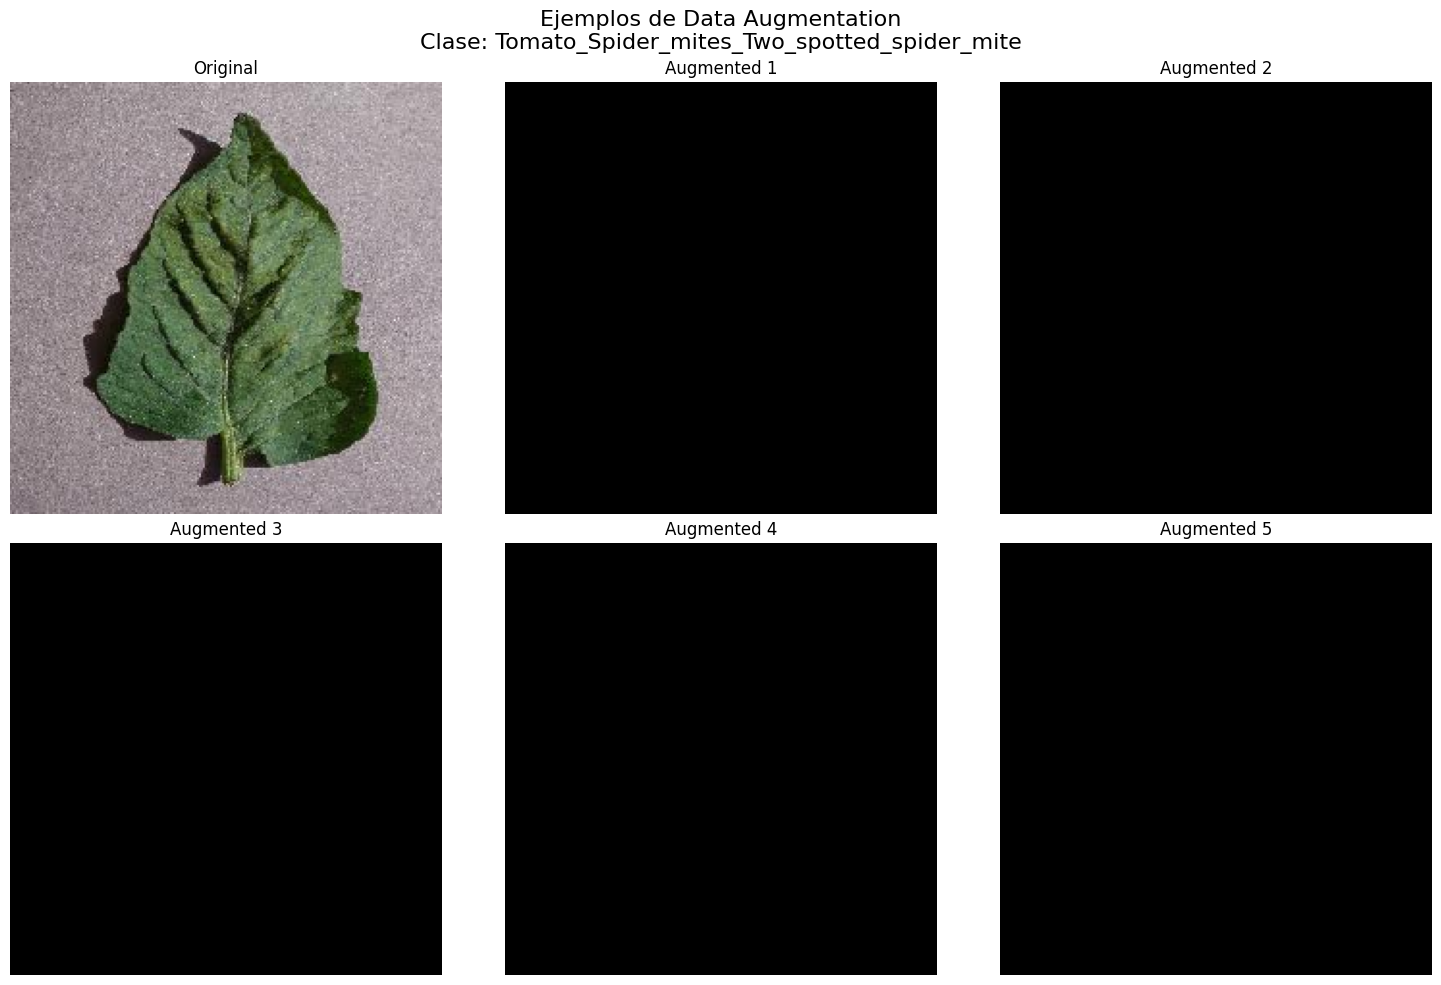

In [ ]:
# Visualizar ejemplos de augmentación
def mostrar_augmentacion(train_df, datagen, num_ejemplos=5):
    """
    Muestra ejemplos de augmentación de datos
    """
    # Seleccionar una imagen aleatoria
    sample_row = train_df.sample(1).iloc[0]
    img_path = sample_row['ruta']
    
    # Cargar imagen original
    img = load_img(img_path, target_size=IMG_SIZE)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    # Crear figura
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Mostrar imagen original
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    # Mostrar versiones aumentadas
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        if i >= 5:  # Mostrar 5 ejemplos
            break
        
        row = (i + 1) // 3
        col = (i + 1) % 3
        
        axes[row, col].imshow((batch[0] * 255).astype('uint8'))
        axes[row, col].set_title(f'Augmented {i+1}')
        axes[row, col].axis('off')
        i += 1
    
    plt.suptitle(f'Ejemplos de Data Augmentation\nClase: {sample_row["clase"]}', fontsize=16)
    plt.tight_layout()
    plt.show()

mostrar_augmentacion(train_df, train_datagen)

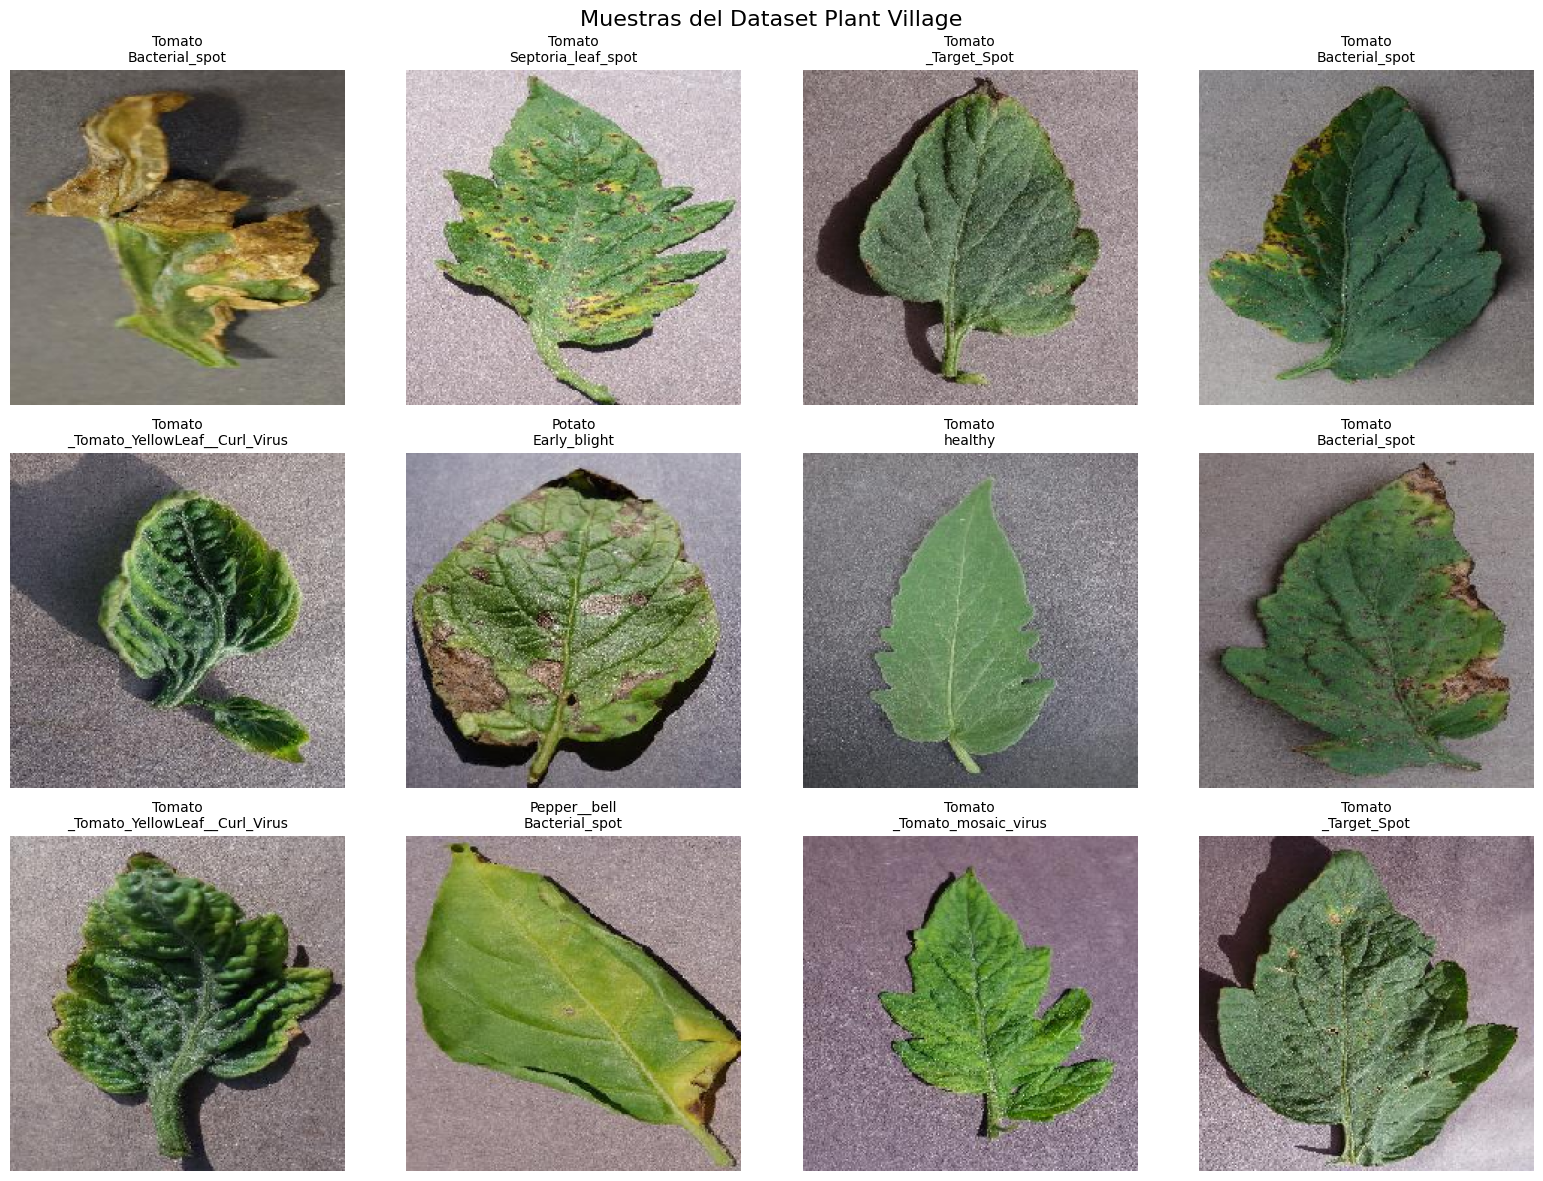

In [12]:
# Función para cargar y preprocesar una imagen individual
def preprocesar_imagen(img_path, target_size=(224, 224)):
    """
    Carga y preprocesa una imagen individual
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Función para mostrar muestras del dataset
def mostrar_muestras_dataset(df, num_muestras=12):
    """
    Muestra muestras aleatorias del dataset
    """
    muestras = df.sample(num_muestras)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, (idx, row) in enumerate(muestras.iterrows()):
        img = load_img(row['ruta'], target_size=IMG_SIZE)
        axes[i].imshow(img)
        axes[i].set_title(f'{row["especie"]}\n{row["condicion"]}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Muestras del Dataset Plant Village', fontsize=16)
    plt.tight_layout()
    plt.show()

mostrar_muestras_dataset(df_imagenes)

In [13]:
# Guardar información para los siguientes notebooks
info_preparacion = {
    'num_clases': len(label_encoder.classes_),
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'total_imagenes': len(df_imagenes),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'clases': label_encoder.classes_.tolist(),
    'especies': df_imagenes['especie'].unique().tolist()
}

import json
with open('info_preparacion.json', 'w') as f:
    json.dump(info_preparacion, f, indent=2)

print("Preparación de datos completada!")
print("\nArchivos generados:")
print("- dataset_info.csv: Información completa del dataset")
print("- train_split.csv, val_split.csv, test_split.csv: Divisiones del dataset")
print("- label_encoder_classes.npy: Clases del codificador de etiquetas")
print("- info_preparacion.json: Información general de la preparación")

print("\nResumen final:")
print(f"- {info_preparacion['num_clases']} clases")
print(f"- {info_preparacion['total_imagenes']} imágenes totales")
print(f"- {len(info_preparacion['especies'])} especies de plantas")
print(f"- Tamaño de imagen: {IMG_SIZE}")

Preparación de datos completada!

Archivos generados:
- dataset_info.csv: Información completa del dataset
- train_split.csv, val_split.csv, test_split.csv: Divisiones del dataset
- label_encoder_classes.npy: Clases del codificador de etiquetas
- info_preparacion.json: Información general de la preparación

Resumen final:
- 13 clases
- 17776 imágenes totales
- 3 especies de plantas
- Tamaño de imagen: (224, 224)
